In [96]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *

import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
latent_dims = 20 # 6 # 17
device = 'cuda' if torch.cuda.is_available() else 'cpu'
periode = 2 #days
step = 5 # mess interval in minutes
val = 500
n_channels = 1
n_samples = 500
bs=50
L= 576
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":1.5,   
        "interval":4000,
        "start":5000
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.08,
        "type":"linear",
        "start":0
        },
    "Seasonality": {
        "occurances":0,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":1000,
        "interval":None,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


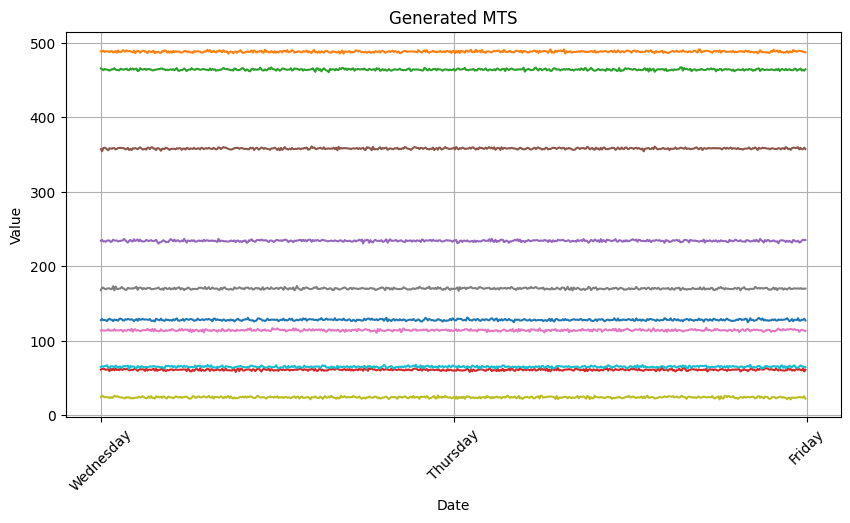

torch.Size([5000, 3])
tensor([[        0.,         0.,       128.],
        [        1.,         0.,       488.],
        [        2.,         0.,       464.],
        ...,
        [     4997.,         0.,       186.],
        [     4998.,         0.,         6.],
        [     4999.,         0.,       350.]])
generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


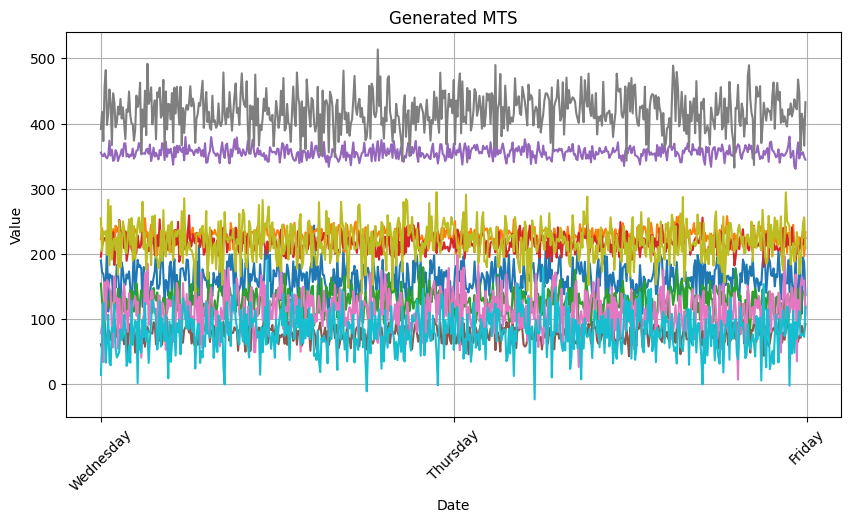

torch.Size([5000, 3])
tensor([[        0.,         0.,       162.],
        [        1.,         0.,       228.],
        [        2.,         0.,       128.],
        ...,
        [     4997.,         0.,        81.],
        [     4998.,         0.,       226.],
        [     4999.,         0.,       373.]])
generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


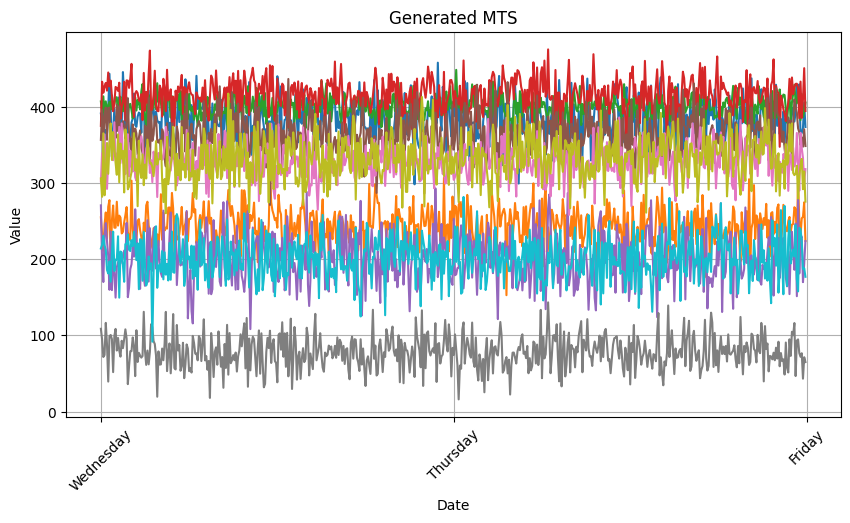

torch.Size([5000, 3])
tensor([[        0.,         0.,       382.],
        [        1.,         0.,       244.],
        [        2.,         0.,       401.],
        ...,
        [     4997.,         0.,        14.],
        [     4998.,         0.,       262.],
        [     4999.,         0.,       415.]])
generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


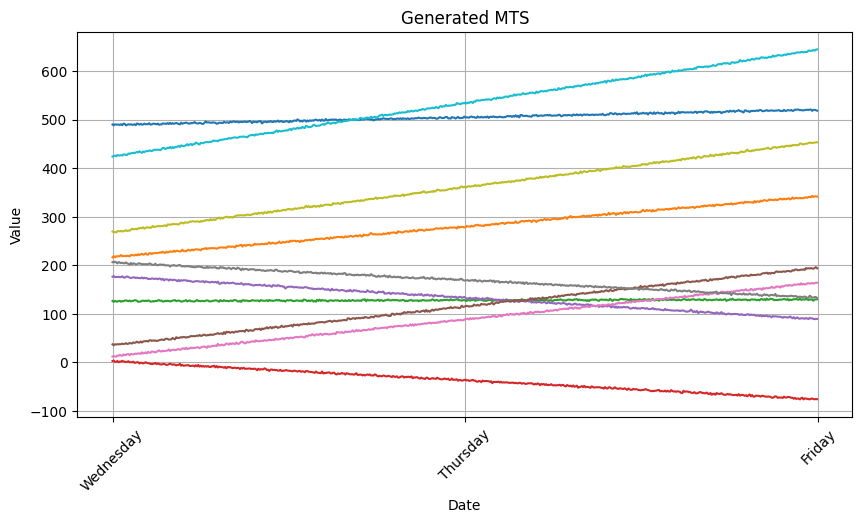

torch.Size([5000, 3])
tensor([[        0.,         0.,       489.],
        [        1.,         0.,       217.],
        [        2.,         0.,       126.],
        ...,
        [     4997.,         0.,       445.],
        [     4998.,         0.,       416.],
        [     4999.,         0.,       169.]])
generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


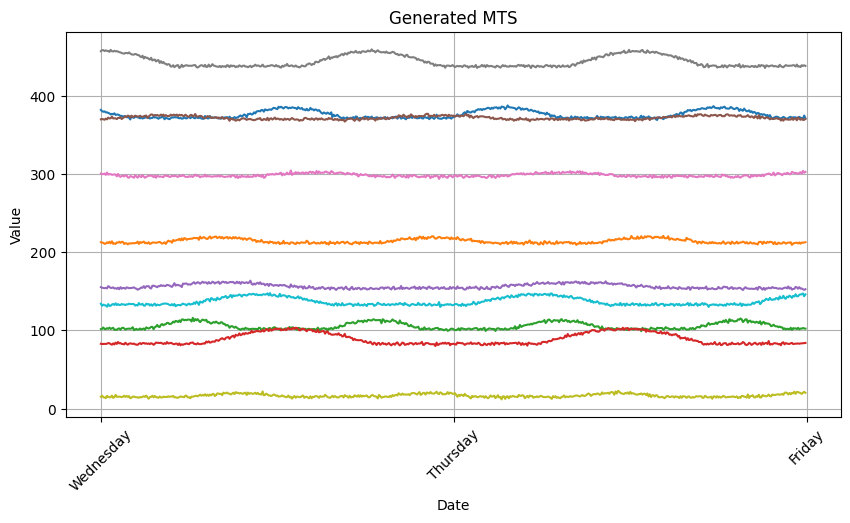

torch.Size([5000, 3])
tensor([[        0.,         0.,       372.],
        [        1.,         0.,       212.],
        [        2.,         0.,       102.],
        ...,
        [     4997.,         0.,       466.],
        [     4998.,         0.,       221.],
        [     4999.,         0.,       179.]])
generating:  0
generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8


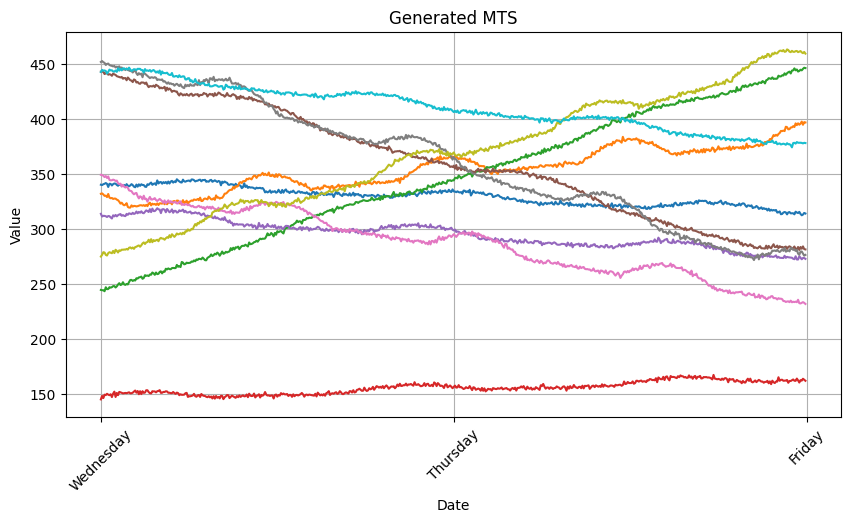

torch.Size([5000, 3])
tensor([[        0.,         0.,       341.],
        [        1.,         0.,       318.],
        [        2.,         0.,       244.],
        ...,
        [     4997.,         0.,       425.],
        [     4998.,         0.,       136.],
        [     4999.,         0.,       273.]])


In [152]:
train_data_mean, val_data_mean, test_data_mean = generate_labeled_data(effects, n_channels=n_channels, batch_size=40, periode=periode, effect="no_effect", occurance=1, norm=False)
train_data_std, val_data_std, test_data_std = generate_labeled_data(effects, batch_size=40, periode=periode, effect="std_variation", occurance=1, norm=False)
train_data_std_norm, val_data_std_norm, test_data_std_norm = generate_labeled_data(effects, batch_size=40, periode=periode, effect="std_variation", occurance=1)
train_data_trend, val_data_trend, test_data_trend = generate_labeled_data(effects, batch_size=40, periode=periode, effect="Trend", occurance=1)
train_data_seas, val_data_seas, test_data_seas = generate_labeled_data(effects, batch_size=40, periode=periode, effect="Seasonality", occurance=1)
train_data_both, val_data_both, test_data_both = generate_labeled_data(effects, batch_size=40, periode=periode, effect="both", occurance=1)


In [167]:
from importlib import reload
# reload(RnnEncoder)
# reload(RnnDecoder)
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
### Init Model
latent_dims = 20 # 6 # 17
# L= 576 # train_data.dataset.n #2016# 39 #32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

VAEs = []
VQs  = []
for i in range(6):
    
    vae = Variational_Autoencoder(n_channels = n_channels,
                                num_layers = 4,#4, #3
                                latent_dims= latent_dims,
                                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                                L=L,
                                slope = 0,
                                first_kernel = 252, #11, #20
                                ß = 1.5,
                                modified=False,
                                reduction = True)
    vq = VQ_MST_VAE(n_channels = n_channels,
                                num_layers =  3,#4, #3
                                latent_dims= latent_dims,
                                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                                v_quantizer = VQ_Quantizer,
                                L=L,
                                slope = 0,
                                first_kernel = 256, #11, #20
                                commit_loss = 1.5,
                                modified=True,
                                reduction = True) #10 5
    vae = vae.to(device)
    vq = vq.to(device)
    
    opt_vae = optim.Adam(vae.parameters(), lr = 0.02043529186448577) # 0.005043529186448577 0.006819850049647945
    opt_vq = optim.Adam(vq.parameters(), lr = 0.02043529186448577)

    VAEs.append(vae)
    VQs.append(vq)
# v = VQ_MST_VAE(n_channels = n_channels,
#                             num_layers =  4,#4, #3
#                             latent_dims= latent_dims,
#                             v_encoder = RnnEncoder, #RnnEncoder, # LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = RnnDecoder, #RnnDecoder, # LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                             v_quantizer = VQ_Quantizer,
#                             L=L,
#                             slope = 0,
#                             first_kernel = 1008, #11, #20
#                             commit_loss = 1.5,
#                             modified=True,
#                             reduction = True) #10 5




# encoder_vae = vae.encoder
# opt_enc_vae = optim.Adam(encoder_vae.parameters(), lr=0.0001)

# encoder_vq = vq.encoder
# opt_enc_vq = optim.Adam(encoder_vq.parameters(), lr=0.0001)

# decoder_vae = vae.decoder
# opt_dec_vae = optim.Adam(decoder_vae.parameters(), lr=0.0001)

# decoder_vq = vq.decoder
# opt_dec_vq = optim.Adam(decoder_vq.parameters(), lr=0.0001)

# opt_vae = optim.Adam(vae.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945
# opt_vq = optim.Adam(vq.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945

print(vae)

1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
Variational_Autoencoder(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(1, 2, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(2, 4, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(4, 6, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Conv1d(6, 8, kernel_size=(2,), stride=(2,))
        (10): LeakyReLU(negative_slope=0, inplace=True)
        (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [148]:
len(VAEs)

5

In [154]:
from IPython import display
def rebuild_TS(model, train_loader, batch_size=50):
    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

    data_shape = train_loader.dataset.data.shape 
    e_indices = torch.empty(data_shape[0]*6, (data_shape[1] - model._L))

    Origin = torch.empty(data_shape)
    REC = torch.empty(data_shape)

    idx = 0
    for sample_idx, (data, label, norm) in enumerate(train_loader):
       
        data = data.to(device) 
        norm = norm.view(-1,1,1).to(device)
        bs   = data.shape[0]
        print(data)
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data, ouput_indices=True)
        
#         print("Quantizer Output shape: ", e.shape)
#         print("model output in each bach", x_rec.shape)
#         print("What we take", x_rec[..., 0].T.shape)
#         print("Where we save it", REC[:, idx: idx+bs].shape)
#         print("The index we save at", idx)
#         print("\n\n")
#         print("the model indices output: ", indices.shape)
#         print("the model indices output reshaped = : ", indices.view(data_shape[0]*6, -1).shape)
#         print("our target shape is: ", e_indices[..., idx: (idx+bs)].shape)
        e_indices[..., idx: (idx+bs)] = indices.view(data_shape[0]*6, -1)
        Origin[..., idx: idx+bs] = (norm * data)[..., 0].T
        REC[..., idx: idx+bs] = (norm * x_rec)[..., 0].T        
        idx += bs
        
        if bs != batch_size:            
#             print("---------Final batch--------")
#             print("The index we save at", idx)
#             print("the rest of e_indices: ", e_indices[idx:].shape)
#             print("e_indices shape: ", e_indices.shape)
#             print("We take the full last sample", x_rec[-1].shape)
#             print("We fill the rest of REC", REC[:, idx:].shape)
#             e_indices[idx:] = indices.squeeze()
            Origin[..., idx:] = (norm*data)[-1]
            REC[..., idx:] = (norm*x_rec)[-1]
    return Origin, REC, e_indices

def plot_heatmap(ax_heatmap, codebook):
    ax_heatmap.clear()
    heatmap = ax_heatmap.imshow(codebook)
    ax_heatmap.set_title('Codebook Heatmap')
    ax_heatmap


    return heatmap
def create_heatmap(codebook):
    fig, ax_heatmap = plt.subplots(figsize=(12, 6), dpi=100)
    heatmap = plot_heatmap(ax_heatmap, codebook.T)
#     heatmap_canvas = FigureCanvasTkAgg(fig, master=heatmap_frame)
#     heatmap_canvas.draw()
#     heatmap_canvas.get_tk_widget().pack(fill="both", expand=True)
    cbar = fig.colorbar(heatmap)
    ax_heatmap.set_xlabel('Num of Embeddings')
    ax_heatmap.set_ylabel('Latent Dimensions')
    plt.show()
    
    return ax_heatmap

def plot_rec(origin, rec, title="Reconstruction"):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec, "r--", alpha = 0.5, label="Rec")
    ax.plot(origin, "b-", alpha=0.2, label="Origin")
    
#     display.clear_output(wait=True)
    if title != None:
        ax.set_title(title)
    ax.grid()
    ax.legend()
    plt.show()
    
def plot_indices(indices):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(indices.T[:60, :6], alpha = 0.5)
#     ax.ylim(0:100)

    if title != None:
        ax.set_title(title)
#     display.clear_output(wait=True)
    ax.grid()
    plt.show()

def plot_losses(loss_vae, loss_vq, title=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(loss_vae, "r--", label="VAE", alpha = 0.5)
    ax.plot(loss_vq, "b--", label= "VQ", alpha = 0.5)
    
#     plt.ylim(0,2000)
    
#     display.clear_output(wait=True)
    ax.grid()
    ax.legend()
    plt.show()

In [168]:
def train(model, train_loader, optimizer, device, epoch):
    model.to(device)
    model.train()
    for p in model.parameters():
        p.requires_grad = True

    sample_loss = 0
    losses = []
    eps = 1e-10
    steps_per_epoch = len(train_loader)


    for sample_idx, (data, label, norm) in enumerate(train_loader):

        data = data.to(device) 
        label = label[:,:,1].to(device)
        norm = norm.view(-1,1,1).to(device)
        norm_cpu = norm.detach().cpu() 
        
        x_rec, loss_rec, loss_e, mu, logvar, mu_rec, logvar_rec, e = model(data, split_loss=True)  

        loss = loss_rec + loss_e
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
        if sample_idx % 20 == 0:
#             print("--------new Samples------------")
            print('Sample Epoch: {} [{}/{} ({:.0f}%)]\tLoss VQ/VAE: {:.6f}'.format(
                epoch, sample_idx, len(train_loader),
                       100. * sample_idx / len(train_loader), loss, ))
            print('\nLoss rec: {:.6f}\tLoss ema/KL: {:.6f}'.format(loss_rec, loss_e))

    ts_to_display = torch.randint(0, 40, (1,)).item()
    Origin = (norm* data)[ts_to_display, 0,:2000].cpu()
    REC = (norm * x_rec)[ts_to_display,0,:2000].detach().cpu()
    

    return losses, Origin, REC

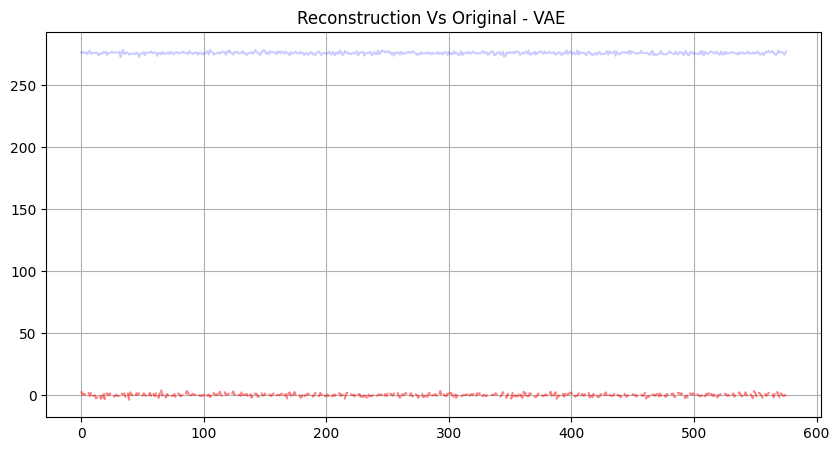

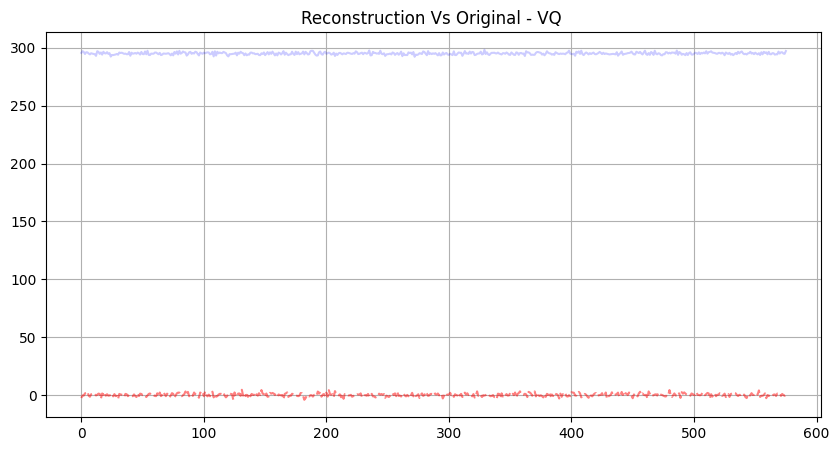

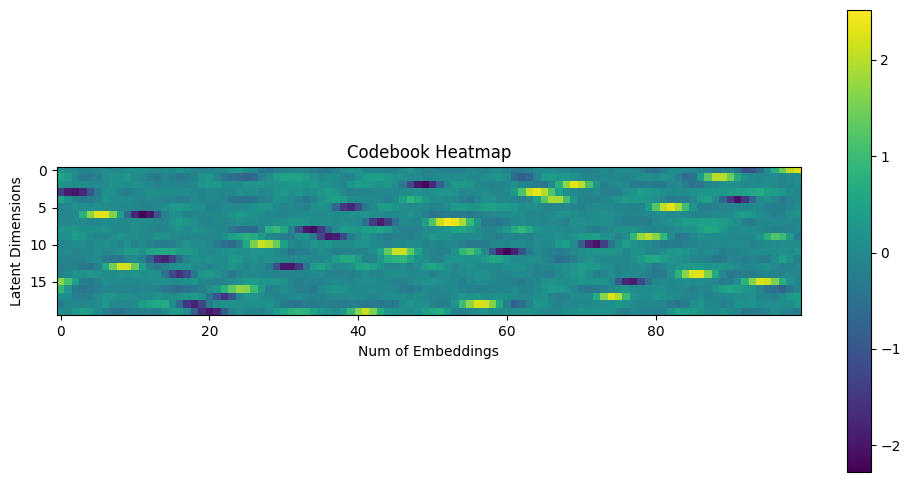

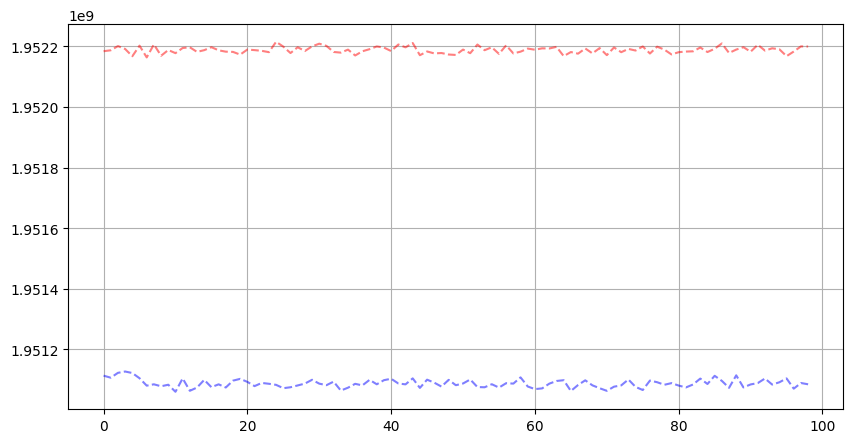

In [161]:
VAE_loss_mean, VQ_loss_mean= [], []
max_length = 2000
for epoch in range(1, 100):
    
    vae_loss, origin_vae, rec_vae = train(VAEs[0], train_data_mean, opt_vae, device, epoch)
    vq_loss, origin_vq, rec_vq = train(VQs[0], train_data_mean, opt_vae, device, epoch)

    VAE_loss_mean.append(np.mean(vae_loss))
    VQ_loss_mean.append(np.mean(vq_loss))
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
    
    display.clear_output(wait=True)
#     f1, ax1 = plt.subplots(figsize = (8,5))
    
    plot_rec(origin_vae, rec_vae, "Reconstruction Vs Original - VAE ")
    plot_rec(origin_vq, rec_vq, "Reconstruction Vs Original - VQ ")
    codebook = VQs[0].quantizer._embedding.weight
    heatmap = create_heatmap(codebook.cpu().detach().numpy() )
    plot_losses(VAE_loss_mean, VQ_loss_mean, "Avg Loss")


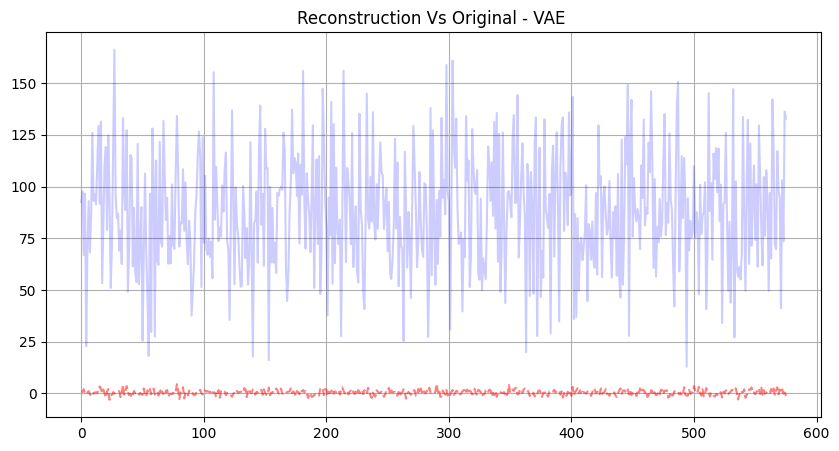

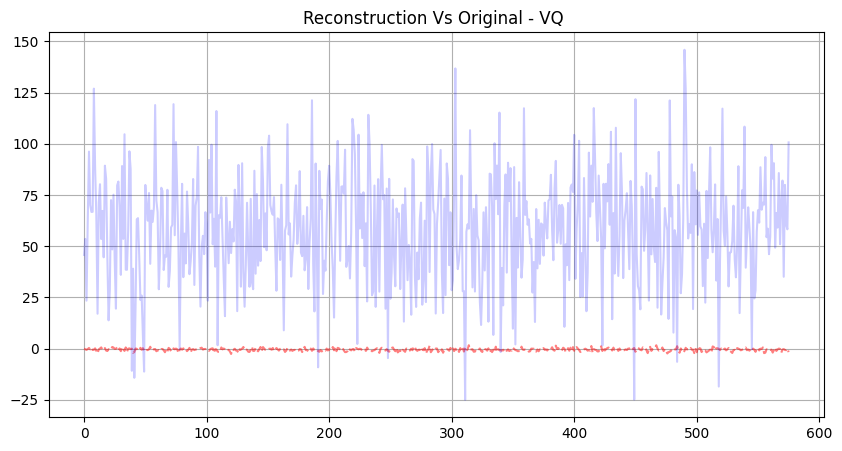

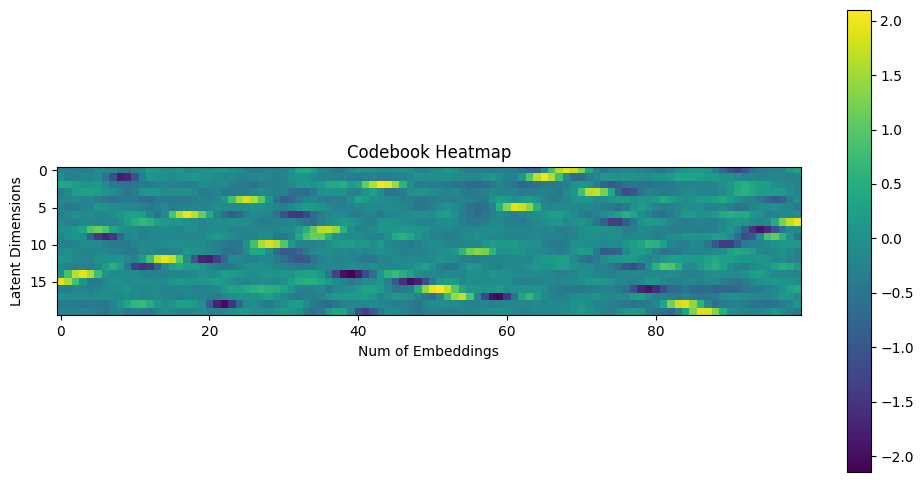

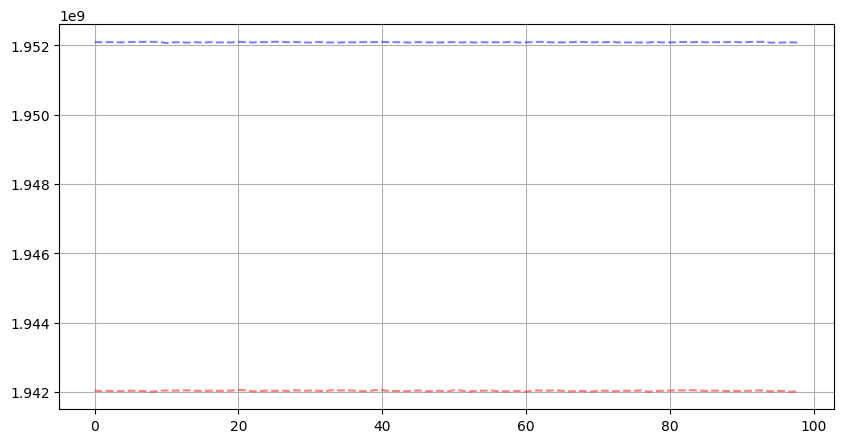

In [158]:
VAE_loss_std, VQ_loss_std= [], []
max_length = 2000
for epoch in range(1, 100):
    
    vae_loss, origin_vae, rec_vae = train(VAEs[1], train_data_std, opt_vae, device, epoch)
    vq_loss, origin_vq, rec_vq = train(VQs[1], train_data_std, opt_vae, device, epoch)

    VAE_loss_std.append(np.mean(vae_loss))
    VQ_loss_std.append(np.mean(vq_loss))
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
    
    display.clear_output(wait=True)
#     f1, ax1 = plt.subplots(figsize = (8,5))
    
    plot_rec(origin_vae, rec_vae, "Reconstruction Vs Original - VAE ")
    plot_rec(origin_vq, rec_vq, "Reconstruction Vs Original - VQ ")
    codebook = VQs[0].quantizer._embedding.weight
    heatmap = create_heatmap(codebook.cpu().detach().numpy() )
    plot_losses(VAE_loss_std, VQ_loss_std, "Avg Loss")

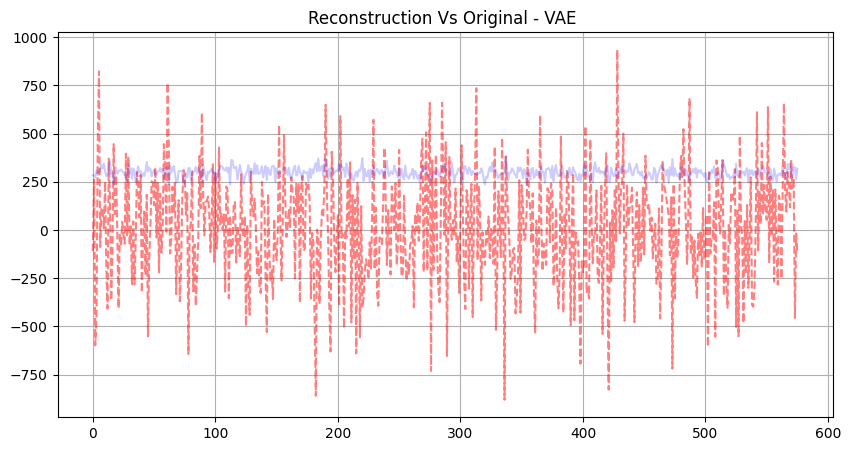

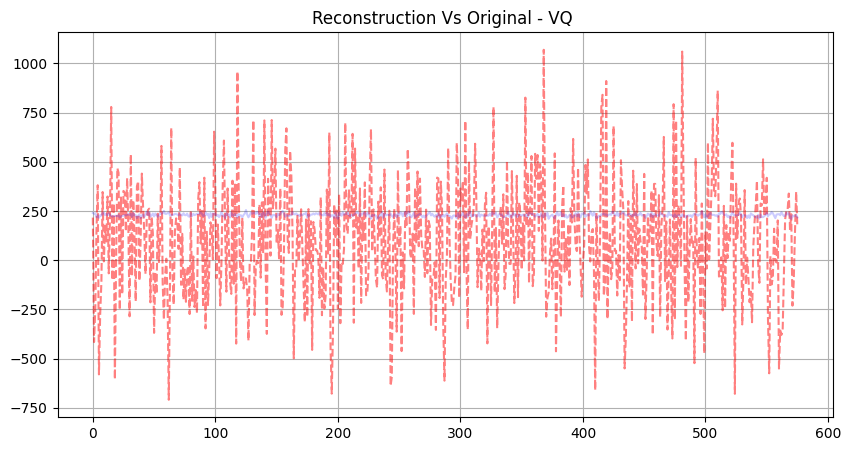

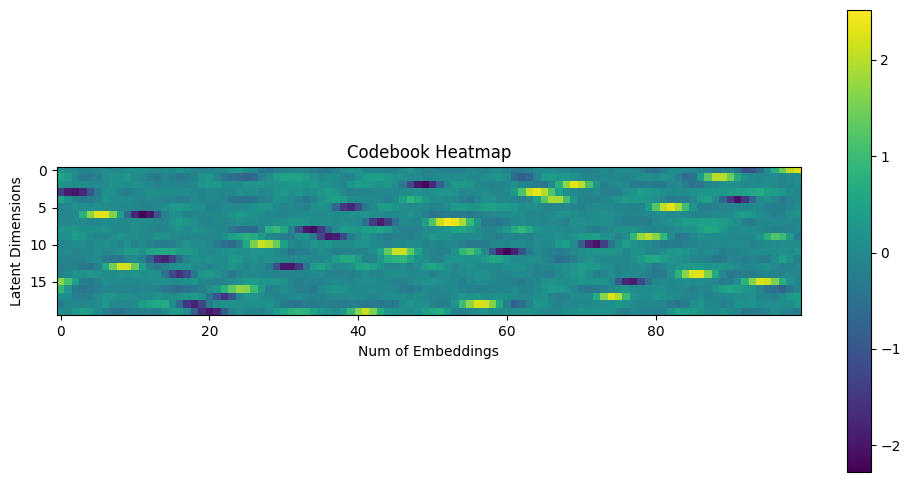

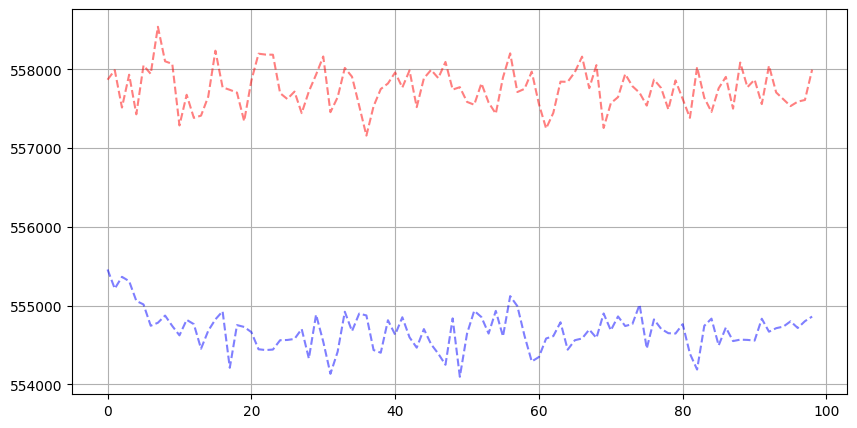

In [162]:
VAE_loss_std_norm, VQ_loss_std_norm= [], []
max_length = 2000
for epoch in range(1, 100):
    
    vae_loss, origin_vae, rec_vae = train(VAEs[1], train_data_std_norm, opt_vae, device, epoch)
    vq_loss, origin_vq, rec_vq = train(VQs[1], train_data_std_norm, opt_vae, device, epoch)

    VAE_loss_std_norm.append(np.mean(vae_loss))
    VQ_loss_std_norm.append(np.mean(vq_loss))
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
    
    display.clear_output(wait=True)
#     f1, ax1 = plt.subplots(figsize = (8,5))
    
    plot_rec(origin_vae, rec_vae, "Reconstruction Vs Original - VAE ")
    plot_rec(origin_vq, rec_vq, "Reconstruction Vs Original - VQ ")
    codebook = VQs[0].quantizer._embedding.weight
    heatmap = create_heatmap(codebook.cpu().detach().numpy() )
    plot_losses(VAE_loss_std_norm, VQ_loss_std_norm, "Avg Loss")

In [171]:
VAE_loss_trend, VQ_loss_trend= [], []
max_length = 2000
for epoch in range(1, 100):
    
    vae_loss, origin_vae, rec_vae = train(VAEs[2], train_data_trend, opt_vae, device, epoch)
    vq_loss, origin_vq, rec_vq = train(VQs[2], train_data_trend, opt_vae, device, epoch)

    VAE_loss_trend.append(np.mean(vae_loss))
    VQ_loss_trend.append(np.mean(vq_loss))
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
    
    display.clear_output(wait=True)
#     f1, ax1 = plt.subplots(figsize = (8,5))
    if epoch%50 ==0:
        plot_rec(origin_vae, rec_vae, "Reconstruction Vs Original - VAE ")
        plot_rec(origin_vq, rec_vq, "Reconstruction Vs Original - VQ ")
        codebook = VQs[0].quantizer._embedding.weight
        heatmap = create_heatmap(codebook.cpu().detach().numpy() )
        plot_losses(VAE_loss_trend, VQ_loss_trend, "Avg Loss")

Sample Epoch: 99 [0/100 (0%)]	Loss VQ/VAE: 50678.246094

Loss rec: 50406.460938	Loss ema/KL: 271.787048
Sample Epoch: 99 [20/100 (20%)]	Loss VQ/VAE: 47456.042969

Loss rec: 47208.523438	Loss ema/KL: 247.521362
Sample Epoch: 99 [40/100 (40%)]	Loss VQ/VAE: 51355.390625

Loss rec: 51109.914062	Loss ema/KL: 245.477829
Sample Epoch: 99 [60/100 (60%)]	Loss VQ/VAE: 71009.140625

Loss rec: 70766.492188	Loss ema/KL: 242.645828
Sample Epoch: 99 [80/100 (80%)]	Loss VQ/VAE: 95529.718750

Loss rec: 95279.656250	Loss ema/KL: 250.066254
Sample Epoch: 99 [0/100 (0%)]	Loss VQ/VAE: 7282366.500000

Loss rec: 7282363.500000	Loss ema/KL: 2.922393
Sample Epoch: 99 [20/100 (20%)]	Loss VQ/VAE: 72201.328125

Loss rec: 72198.664062	Loss ema/KL: 2.667847
Sample Epoch: 99 [40/100 (40%)]	Loss VQ/VAE: 72578.390625

Loss rec: 72575.875000	Loss ema/KL: 2.517830
Sample Epoch: 99 [60/100 (60%)]	Loss VQ/VAE: 123639.734375

Loss rec: 123637.000000	Loss ema/KL: 2.730474
Sample Epoch: 99 [80/100 (80%)]	Loss VQ/VAE: 118544.

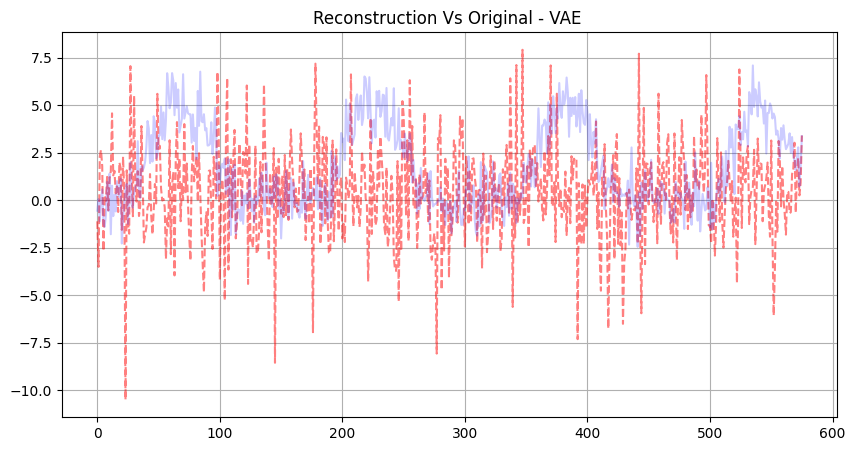

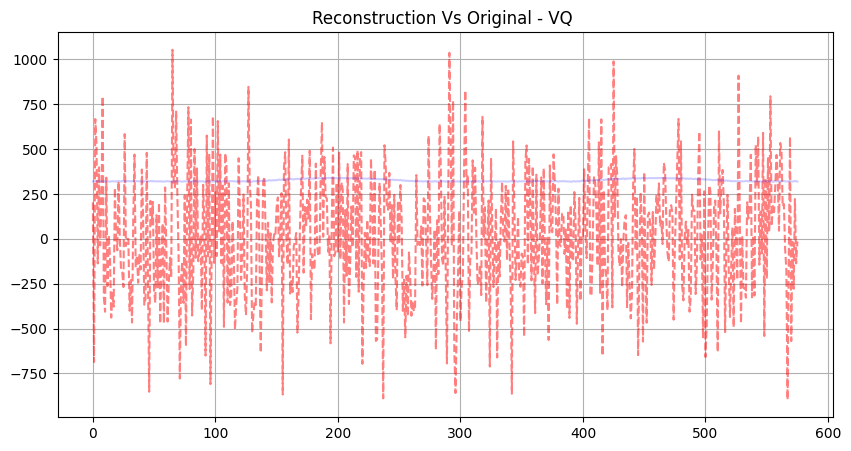

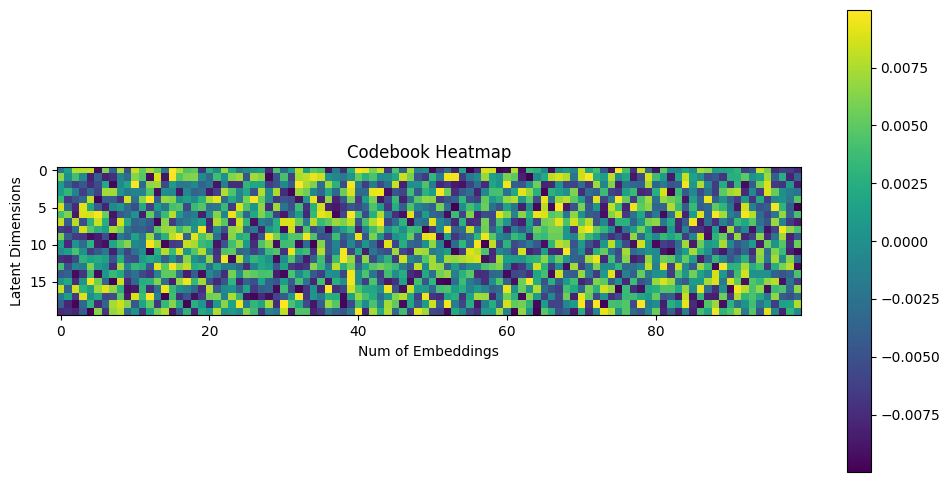

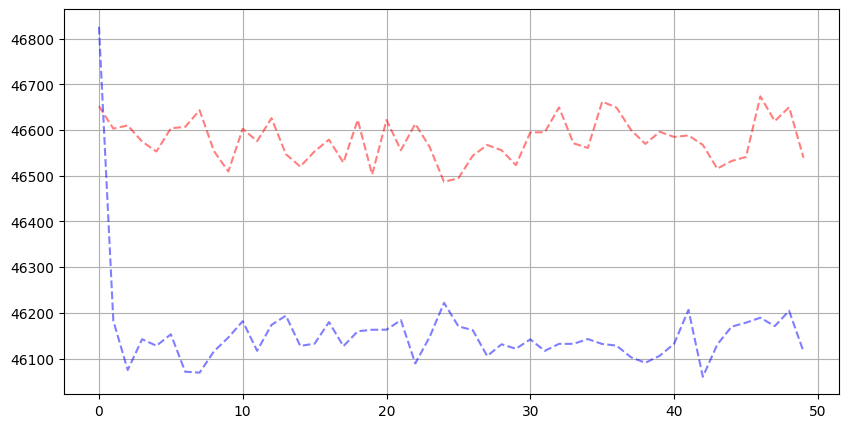

Sample Epoch: 51 [0/100 (0%)]	Loss VQ/VAE: 45723.695312

Loss rec: 45384.937500	Loss ema/KL: 338.757019
Sample Epoch: 51 [20/100 (20%)]	Loss VQ/VAE: 46060.375000

Loss rec: 45717.781250	Loss ema/KL: 342.594177
Sample Epoch: 51 [40/100 (40%)]	Loss VQ/VAE: 45986.101562

Loss rec: 45635.355469	Loss ema/KL: 350.746338
Sample Epoch: 51 [60/100 (60%)]	Loss VQ/VAE: 47085.242188

Loss rec: 46717.953125	Loss ema/KL: 367.287567
Sample Epoch: 51 [80/100 (80%)]	Loss VQ/VAE: 45894.628906

Loss rec: 45544.414062	Loss ema/KL: 350.215698
Sample Epoch: 51 [0/100 (0%)]	Loss VQ/VAE: 46377.433594

Loss rec: 46375.062500	Loss ema/KL: 2.369967
Sample Epoch: 51 [20/100 (20%)]	Loss VQ/VAE: 45933.445312

Loss rec: 45931.250000	Loss ema/KL: 2.196833
Sample Epoch: 51 [40/100 (40%)]	Loss VQ/VAE: 46066.601562

Loss rec: 46063.980469	Loss ema/KL: 2.620602
Sample Epoch: 51 [60/100 (60%)]	Loss VQ/VAE: 45557.707031

Loss rec: 45555.414062	Loss ema/KL: 2.292515
Sample Epoch: 51 [80/100 (80%)]	Loss VQ/VAE: 46113.425781


Sample Epoch: 58 [80/100 (80%)]	Loss VQ/VAE: 46339.242188

Loss rec: 46336.925781	Loss ema/KL: 2.316043
Sample Epoch: 59 [0/100 (0%)]	Loss VQ/VAE: 45880.621094

Loss rec: 45559.835938	Loss ema/KL: 320.783508
Sample Epoch: 59 [20/100 (20%)]	Loss VQ/VAE: 46271.402344

Loss rec: 45936.554688	Loss ema/KL: 334.847290
Sample Epoch: 59 [40/100 (40%)]	Loss VQ/VAE: 46050.542969

Loss rec: 45720.546875	Loss ema/KL: 329.997803
Sample Epoch: 59 [60/100 (60%)]	Loss VQ/VAE: 46611.308594

Loss rec: 46248.593750	Loss ema/KL: 362.712921
Sample Epoch: 59 [80/100 (80%)]	Loss VQ/VAE: 46481.453125

Loss rec: 46117.898438	Loss ema/KL: 363.554749
Sample Epoch: 59 [0/100 (0%)]	Loss VQ/VAE: 45856.988281

Loss rec: 45854.671875	Loss ema/KL: 2.314704
Sample Epoch: 59 [20/100 (20%)]	Loss VQ/VAE: 47003.019531

Loss rec: 47000.742188	Loss ema/KL: 2.278082
Sample Epoch: 59 [40/100 (40%)]	Loss VQ/VAE: 45850.117188

Loss rec: 45847.820312	Loss ema/KL: 2.298323
Sample Epoch: 59 [60/100 (60%)]	Loss VQ/VAE: 46942.105469


Sample Epoch: 66 [60/100 (60%)]	Loss VQ/VAE: 45353.082031

Loss rec: 45350.816406	Loss ema/KL: 2.266202
Sample Epoch: 66 [80/100 (80%)]	Loss VQ/VAE: 45487.445312

Loss rec: 45485.003906	Loss ema/KL: 2.440317
Sample Epoch: 67 [0/100 (0%)]	Loss VQ/VAE: 46438.585938

Loss rec: 46095.371094	Loss ema/KL: 343.215149
Sample Epoch: 67 [20/100 (20%)]	Loss VQ/VAE: 47903.074219

Loss rec: 47543.406250	Loss ema/KL: 359.667572
Sample Epoch: 67 [40/100 (40%)]	Loss VQ/VAE: 46258.421875

Loss rec: 45909.378906	Loss ema/KL: 349.042603
Sample Epoch: 67 [60/100 (60%)]	Loss VQ/VAE: 45807.714844

Loss rec: 45451.554688	Loss ema/KL: 356.158936
Sample Epoch: 67 [80/100 (80%)]	Loss VQ/VAE: 46389.574219

Loss rec: 46037.660156	Loss ema/KL: 351.913940
Sample Epoch: 67 [0/100 (0%)]	Loss VQ/VAE: 45746.417969

Loss rec: 45744.164062	Loss ema/KL: 2.253448
Sample Epoch: 67 [20/100 (20%)]	Loss VQ/VAE: 46223.722656

Loss rec: 46221.382812	Loss ema/KL: 2.340609
Sample Epoch: 67 [40/100 (40%)]	Loss VQ/VAE: 46865.824219


Sample Epoch: 74 [40/100 (40%)]	Loss VQ/VAE: 45831.664062

Loss rec: 45829.359375	Loss ema/KL: 2.304971
Sample Epoch: 74 [60/100 (60%)]	Loss VQ/VAE: 45767.863281

Loss rec: 45765.683594	Loss ema/KL: 2.179787
Sample Epoch: 74 [80/100 (80%)]	Loss VQ/VAE: 46193.152344

Loss rec: 46190.843750	Loss ema/KL: 2.310441
Sample Epoch: 75 [0/100 (0%)]	Loss VQ/VAE: 46575.546875

Loss rec: 46249.617188	Loss ema/KL: 325.931519
Sample Epoch: 75 [20/100 (20%)]	Loss VQ/VAE: 46252.875000

Loss rec: 45914.351562	Loss ema/KL: 338.524536
Sample Epoch: 75 [40/100 (40%)]	Loss VQ/VAE: 45974.906250

Loss rec: 45633.054688	Loss ema/KL: 341.852661
Sample Epoch: 75 [60/100 (60%)]	Loss VQ/VAE: 46396.042969

Loss rec: 46040.695312	Loss ema/KL: 355.348267
Sample Epoch: 75 [80/100 (80%)]	Loss VQ/VAE: 46376.800781

Loss rec: 46027.472656	Loss ema/KL: 349.329773
Sample Epoch: 75 [0/100 (0%)]	Loss VQ/VAE: 46099.453125

Loss rec: 46097.207031	Loss ema/KL: 2.247398
Sample Epoch: 75 [20/100 (20%)]	Loss VQ/VAE: 45336.359375


Sample Epoch: 82 [20/100 (20%)]	Loss VQ/VAE: 45520.234375

Loss rec: 45517.796875	Loss ema/KL: 2.437037
Sample Epoch: 82 [40/100 (40%)]	Loss VQ/VAE: 45766.972656

Loss rec: 45764.562500	Loss ema/KL: 2.411439
Sample Epoch: 82 [60/100 (60%)]	Loss VQ/VAE: 46115.976562

Loss rec: 46113.640625	Loss ema/KL: 2.334005
Sample Epoch: 82 [80/100 (80%)]	Loss VQ/VAE: 46515.425781

Loss rec: 46513.027344	Loss ema/KL: 2.398543
Sample Epoch: 83 [0/100 (0%)]	Loss VQ/VAE: 46544.597656

Loss rec: 46207.343750	Loss ema/KL: 337.252197
Sample Epoch: 83 [20/100 (20%)]	Loss VQ/VAE: 46315.574219

Loss rec: 45972.093750	Loss ema/KL: 343.481445
Sample Epoch: 83 [40/100 (40%)]	Loss VQ/VAE: 45764.136719

Loss rec: 45417.156250	Loss ema/KL: 346.981201
Sample Epoch: 83 [60/100 (60%)]	Loss VQ/VAE: 45828.804688

Loss rec: 45487.972656	Loss ema/KL: 340.831055
Sample Epoch: 83 [80/100 (80%)]	Loss VQ/VAE: 47024.500000

Loss rec: 46675.992188	Loss ema/KL: 348.506592
Sample Epoch: 83 [0/100 (0%)]	Loss VQ/VAE: 46670.863281


Sample Epoch: 90 [0/100 (0%)]	Loss VQ/VAE: 45801.234375

Loss rec: 45799.007812	Loss ema/KL: 2.224763
Sample Epoch: 90 [20/100 (20%)]	Loss VQ/VAE: 45446.789062

Loss rec: 45444.496094	Loss ema/KL: 2.292378
Sample Epoch: 90 [40/100 (40%)]	Loss VQ/VAE: 46457.625000

Loss rec: 46455.351562	Loss ema/KL: 2.274314
Sample Epoch: 90 [60/100 (60%)]	Loss VQ/VAE: 45207.156250

Loss rec: 45204.804688	Loss ema/KL: 2.350762
Sample Epoch: 90 [80/100 (80%)]	Loss VQ/VAE: 45809.578125

Loss rec: 45807.289062	Loss ema/KL: 2.290366
Sample Epoch: 91 [0/100 (0%)]	Loss VQ/VAE: 47631.386719

Loss rec: 47282.765625	Loss ema/KL: 348.620941
Sample Epoch: 91 [20/100 (20%)]	Loss VQ/VAE: 46972.039062

Loss rec: 46624.375000	Loss ema/KL: 347.662415
Sample Epoch: 91 [40/100 (40%)]	Loss VQ/VAE: 47857.882812

Loss rec: 47484.976562	Loss ema/KL: 372.907410
Sample Epoch: 91 [60/100 (60%)]	Loss VQ/VAE: 47590.199219

Loss rec: 47239.660156	Loss ema/KL: 350.539307
Sample Epoch: 91 [80/100 (80%)]	Loss VQ/VAE: 47085.902344

L

Sample Epoch: 98 [80/100 (80%)]	Loss VQ/VAE: 46758.492188

Loss rec: 46424.609375	Loss ema/KL: 333.881165
Sample Epoch: 98 [0/100 (0%)]	Loss VQ/VAE: 46493.140625

Loss rec: 46490.707031	Loss ema/KL: 2.433938
Sample Epoch: 98 [20/100 (20%)]	Loss VQ/VAE: 47495.187500

Loss rec: 47492.812500	Loss ema/KL: 2.375000
Sample Epoch: 98 [40/100 (40%)]	Loss VQ/VAE: 46596.988281

Loss rec: 46594.632812	Loss ema/KL: 2.354066
Sample Epoch: 98 [60/100 (60%)]	Loss VQ/VAE: 47473.355469

Loss rec: 47471.031250	Loss ema/KL: 2.324123
Sample Epoch: 98 [80/100 (80%)]	Loss VQ/VAE: 45436.640625

Loss rec: 45434.351562	Loss ema/KL: 2.288652
Sample Epoch: 99 [0/100 (0%)]	Loss VQ/VAE: 45815.929688

Loss rec: 45464.542969	Loss ema/KL: 351.385376
Sample Epoch: 99 [20/100 (20%)]	Loss VQ/VAE: 46062.902344

Loss rec: 45725.320312	Loss ema/KL: 337.580261
Sample Epoch: 99 [40/100 (40%)]	Loss VQ/VAE: 46887.898438

Loss rec: 46518.718750	Loss ema/KL: 369.179718
Sample Epoch: 99 [60/100 (60%)]	Loss VQ/VAE: 46590.304688

L

In [172]:
VAE_loss_seas, VQ_loss_seas= [], []
max_length = 2000
for epoch in range(1, 100):
    
    vae_loss, origin_vae, rec_vae = train(VAEs[3], train_data_seas, opt_vae, device, epoch)
    vq_loss, origin_vq, rec_vq = train(VQs[3], train_data_seas, opt_vae, device, epoch)

    VAE_loss_seas.append(np.mean(vae_loss))
    VQ_loss_seas.append(np.mean(vq_loss))
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
    
    if epoch%50 ==0: 
        display.clear_output(wait=True)
    #     f1, ax1 = plt.subplots(figsize = (8,5))

        plot_rec(origin_vae, rec_vae, "Reconstruction Vs Original - VAE ")
        plot_rec(origin_vq, rec_vq, "Reconstruction Vs Original - VQ ")
        codebook = VQs[0].quantizer._embedding.weight
        heatmap = create_heatmap(codebook.cpu().detach().numpy() )
        plot_losses(VAE_loss_seas, VQ_loss_seas, "Avg Loss")

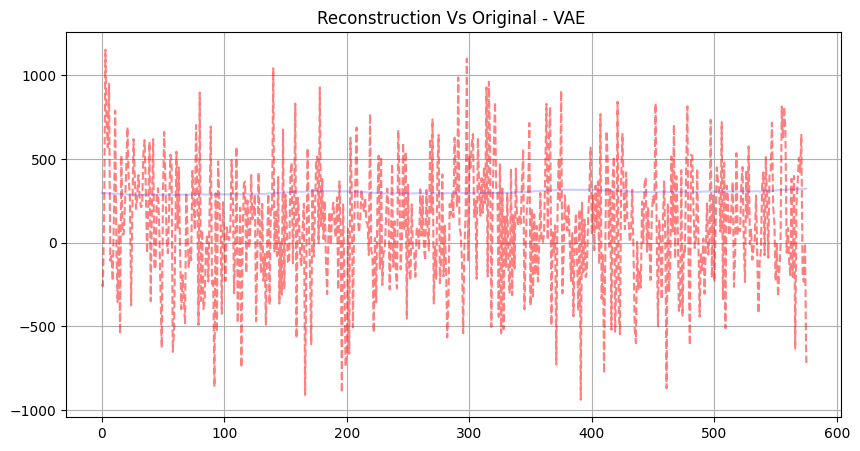

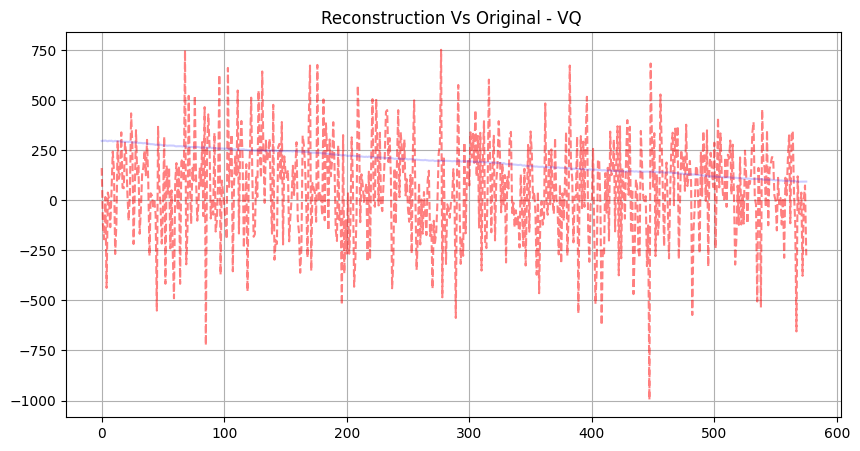

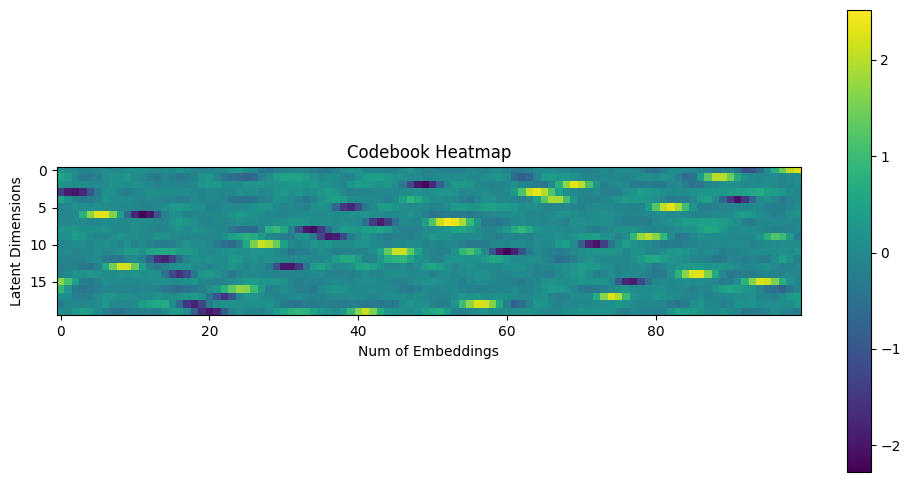

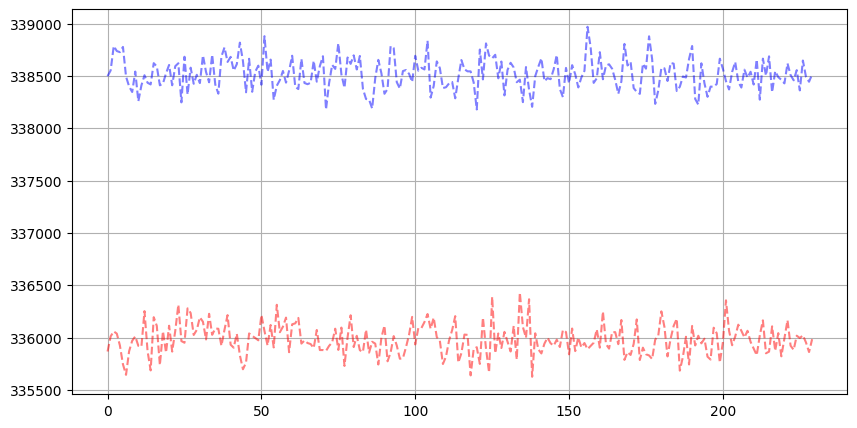

Sample Epoch: 231 [0/100 (0%)]	Loss VQ/VAE: 49729.175781

Loss rec: 49272.542969	Loss ema/KL: 456.633270
Sample Epoch: 231 [20/100 (20%)]	Loss VQ/VAE: 249588.140625

Loss rec: 249104.500000	Loss ema/KL: 483.645447
Sample Epoch: 231 [40/100 (40%)]	Loss VQ/VAE: 81490.609375

Loss rec: 81019.664062	Loss ema/KL: 470.941498
Sample Epoch: 231 [60/100 (60%)]	Loss VQ/VAE: 48324.085938

Loss rec: 47840.074219	Loss ema/KL: 484.012817
Sample Epoch: 231 [80/100 (80%)]	Loss VQ/VAE: 7847159.000000

Loss rec: 7846695.500000	Loss ema/KL: 463.463379
Sample Epoch: 231 [0/100 (0%)]	Loss VQ/VAE: 49209.593750

Loss rec: 49207.359375	Loss ema/KL: 2.232652
Sample Epoch: 231 [20/100 (20%)]	Loss VQ/VAE: 533129.000000

Loss rec: 533126.750000	Loss ema/KL: 2.242342
Sample Epoch: 231 [40/100 (40%)]	Loss VQ/VAE: 77983.898438

Loss rec: 77981.671875	Loss ema/KL: 2.230335
Sample Epoch: 231 [60/100 (60%)]	Loss VQ/VAE: 127896.867188

Loss rec: 127894.671875	Loss ema/KL: 2.198591


KeyboardInterrupt: 

In [166]:
VAE_loss_both, VQ_loss_both= [], []

max_length = 2000
for epoch in range(1, 1000):
    
    vae_loss, origin_vae, rec_vae = train(VAEs[4], train_data_both, opt_vae, device, epoch)
    vq_loss, origin_vq, rec_vq = train(VQs[4], train_data_both, opt_vae, device, epoch)

    VAE_loss_both.append(np.mean(vae_loss))
    VQ_loss_both.append(np.mean(vq_loss))
    if len(VQ_loss) > max_length:
        VQ_loss = VQ_loss[-max_length:]
    
    display.clear_output(wait=True)
#     f1, ax1 = plt.subplots(figsize = (8,5))
    
    plot_rec(origin_vae, rec_vae, "Reconstruction Vs Original - VAE ")
    plot_rec(origin_vq, rec_vq, "Reconstruction Vs Original - VQ ")
    codebook = VQs[0].quantizer._embedding.weight
    heatmap = create_heatmap(codebook.cpu().detach().numpy() )
    plot_losses(VAE_loss_both, VQ_loss_both, "Avg Loss")

In [ ]:
def train_adversial2(model, desc, train_loader, criterion, optimizer, optimizerD, device, epoch):
    model.to(device)
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    desc.to(device)
    desc.train()
    for p in desc.parameters():
        p.requires_grad = True
    sample_loss = 0
    D_losses = []
    VQ_losses = []
    eps = 1e-10
    steps_per_epoch = len(train_loader)
    disc_factor = 1
    disc_start = 20000

    for sample_idx, (data, label, norm) in enumerate(train_loader):
        
        data = data.to(device) 
        label = label[:,:,1].to(device)
        norm = norm.to(device)
        norm_cpu = norm.detach().cpu() 
        
        x_rec, loss_rec, loss_e, mu, logvar, mu_rec, logvar_rec, e = model(data, split_loss=True)  
        
        # Reduce resolution of input and output
        fake_reduced = x_rec #reduce_resolution(x_rec, 5)
        real_reduced = data #reduce_resolution(data, 5)        
            
        # Pass through Descriminator
        disc_real = netD(real_reduced).squeeze()
        disc_fake = netD(fake_reduced).squeeze()
        
        disc_factor = adopt_weight(disc_factor, epoch*steps_per_epoch+sample_idx, threshold=disc_start)
        
        # Generate Labels
        label_real = torch.full((real_reduced.size(0),), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((fake_reduced.size(0),), fake_label, dtype=torch.float, device=device)
        
        # Get desc loss
        d_loss_real = criterion(disc_real + eps, label_real)
        d_loss_fake = criterion(disc_fake + eps, label_fake)       
#         d_loss_real = torch.mean(F.relu(1. - disc_real ))
#         d_loss_fake = torch.mean(F.relu(1. + disc_fake))

        g_loss = torch.mean(1. - disc_fake)


        
        λ = model.calculate_lambda(loss_rec, g_loss)
        
        gan_loss = disc_factor  * 0.5*(d_loss_real + d_loss_fake)

        vq_loss = loss_rec + loss_e + disc_factor * λ * g_loss
        
        optimizer.zero_grad()
        vq_loss.backward(retain_graph=True)

        optimizerD.zero_grad()
        gan_loss.backward()

        optimizer.step()
        if sample_idx % 200 ==0:
            optimizerD.step()
        
        D_losses.append(gan_loss.item())
        VQ_losses.append(vq_loss.item())
        
        if sample_idx % 20 == 0:
#             print("--------new Samples------------")
            print('Sample Epoch: {} [{}/{} ({:.0f}%)]\tLoss VQ/VAE: {:.6f}\tLoss Gan: {:.6f}\t\tScaling Facto: {:.6f}\tLoss g: {:.6f}'.format(
                epoch, sample_idx, len(train_loader),
                       100. * sample_idx / len(train_loader), vq_loss, gan_loss, λ, g_loss))
            print('\nLoss rec: {:.6f}\tLoss ema/KL: {:.6f}\tLoss gan part in VQ: {:.6f}'.format(loss_rec, loss_e, disc_factor * λ * g_loss))
    display.clear_output(wait=True)
    ts_to_display = torch.randint(0, 40, (1,)).item()
    Origin = (norm* data)[ts_to_display, 0,:2000].cpu()
    REC = (norm * x_rec)[ts_to_display,0,:2000].detach().cpu()
    print(e[-1])
        
    return VQ_losses, D_losses, Origin, REC

In [173]:
!pip install torcheck

Looking in indexes: https://nexus.hella.com/repository/pypi/simple, https://pypi.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.6 MB/s eta 0:00:0000:0100:02
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchaudio 2.0.1 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
